# BOTTLE DETECTION using Detr-ResNet

In [1]:
from transformers import DetrFeatureExtractor, DetrForObjectDetection
from PIL import Image
from matplotlib import pyplot as plt
import torch
import requests
from os import listdir

In [3]:
# Set colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

PATH = '../scraping/data/images/'

In [2]:
# Import Model
feature_extractor = DetrFeatureExtractor.from_pretrained('facebook/detr-resnet-50')
model = DetrForObjectDetection.from_pretrained('facebook/detr-resnet-50')

In [12]:
def process_image(image_path, model, feature_extractor, epsilon):
    image = Image.open(image_path)
    inputs = feature_extractor(images=image, return_tensors="pt")
    outputs = model(**inputs)

    # Compute probabilities
    probas = outputs.logits.softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > epsilon

    # Post Process
    target_sizes = torch.tensor(image.size[::-1]).unsqueeze(0)
    postprocessed_outputs = feature_extractor.post_process(outputs, target_sizes)
    bboxes_scaled = postprocessed_outputs[0]['boxes'][keep]

    return image, probas[keep], bboxes_scaled

In [6]:
def plot_results(image, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(image)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{model.config.id2label[cl.item()]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [32]:
def crop_objects(image, prob, boxes, list_objects, save_name):
    for p, (xmin, ymin, xmax, ymax) in zip(prob, boxes.tolist()):
        id = 0
        label = model.config.id2label[p.argmax().item()]

        if label in list_objects:
            im_crop = image.crop((xmin, ymin, xmax, ymax))
            path = save_name+'_'+str(id)+'.png'
            im_crop.save(path)

In [17]:
image, probas, boxes = process_image('../scraping/data/images/345.jpg', model, feature_extractor, 0.1)

D:\Utilisateurs\anaconda3\envs\new\lib\site-packages\transformers\models\detr\modeling_detr.py:422: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.embedding_dim)


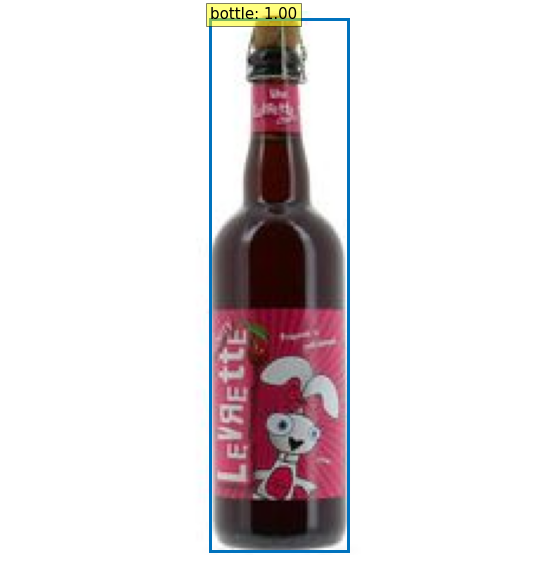

In [18]:
plot_results(image, probas, boxes)

In [33]:
crop_objects(image, probas, boxes, ['bottle'], 'test_1')

(230, 230)
(85.27938842773438, 2.7261099815368652, 143.48602294921875, 227.99087524414062)


## Visualizing attention weights of the last decoder layer

In [117]:
# use lists to store the outputs via up-values
conv_features = []

hooks = [
    model.model.backbone.conv_encoder.register_forward_hook(
        lambda self, input, output: conv_features.append(output)
    ),
]

# propagate through the model
outputs = model(**inputs, output_attentions=True)

for hook in hooks:
    hook.remove()

# don't need the list anymore
conv_features = conv_features[0]
# get cross-attention weights of last decoder layer - which is of shape (batch_size, num_heads, num_queries, width*height)
dec_attn_weights = outputs.cross_attentions[-1]
# average them over the 8 heads and detach from graph
dec_attn_weights = torch.mean(dec_attn_weights, dim=1).detach()

TypeError: 'AxesSubplot' object is not subscriptable

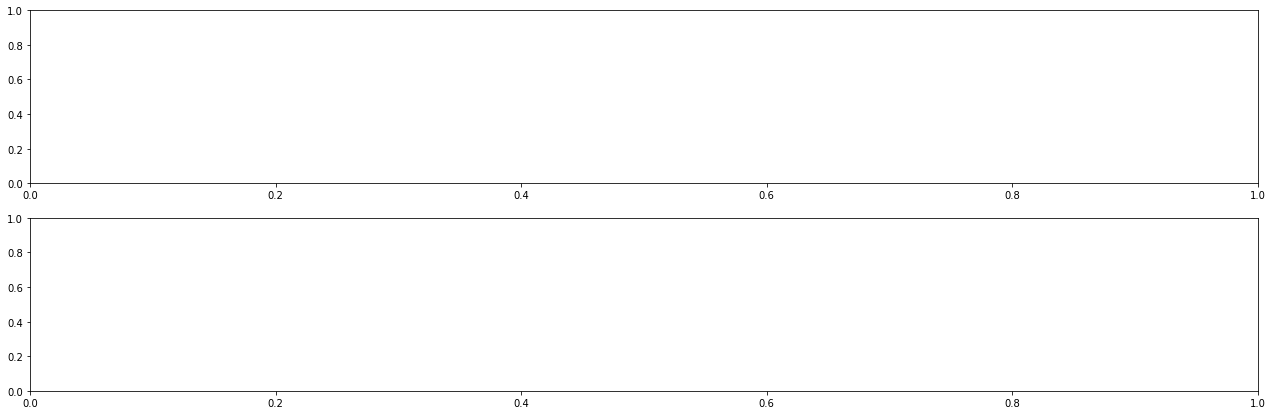

In [121]:
# get the feature map shape
h, w = conv_features[-1][0].shape[-2:]

fig, axs = plt.subplots(ncols=len(bboxes_scaled), nrows=2, figsize=(22, 7))
colors = COLORS * 100
for idx, ax_i, (xmin, ymin, xmax, ymax) in zip(keep.nonzero(), axs.T, bboxes_scaled):
    ax = ax_i[0]
    ax.imshow(dec_attn_weights[0, idx].view(h, w))
    ax.axis('off')
    ax.set_title(f'query id: {idx.item()}')
    ax = ax_i[1]
    ax.imshow(image)
    ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                               fill=False, color='blue', linewidth=3))
    ax.axis('off')
    ax.set_title(model.config.id2label[probas[idx].argmax().item()])
fig.tight_layout()